### Main file

In [1]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *
from tools.parameters_main import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]


/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_kim = load_data('data_kim_200_100')

Data loaded from data/data_kim_200_100.p


In [3]:
data_kim[0].shape

(100, 10, 200)

In [4]:
train_test_kim = train_test_split(data_kim[0], data_kim[1])
len(train_test_kim)

4

In [6]:
# 0 = original pattern
# 1: lowest pattern overlap
# 9: highest pattern overlap
# fist number: batch number
train_test_kim[1][0]

array([[26.,  0.],
       [26.,  1.],
       [26.,  2.],
       [26.,  3.],
       [26.,  4.],
       [26.,  5.],
       [26.,  6.],
       [26.,  7.],
       [26.,  8.],
       [26.,  9.]])

In [39]:
N_v

200

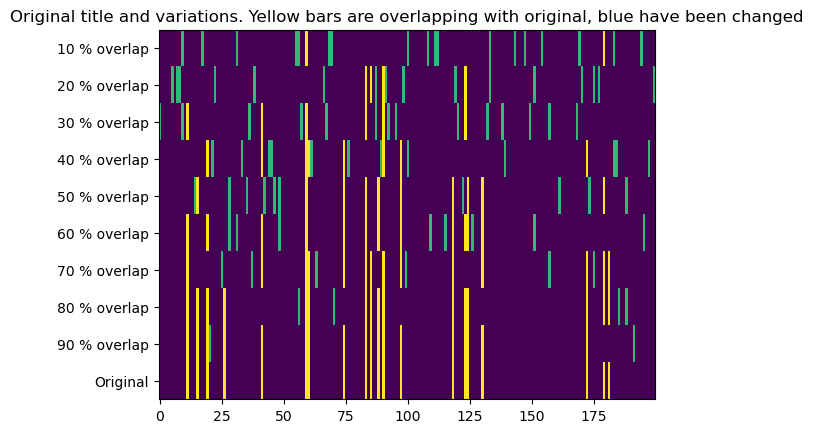

In [54]:
orig_dat = np.row_stack((train_test_kim[0][0][1:], train_test_kim[0][0][0]))
plot_matrix = orig_dat * 2 + np.repeat(train_test_kim[0][0][0], 10).reshape(N_v, 10).T * orig_dat

fig, ax = plt.subplots()
ax.imshow(plot_matrix, aspect="auto", interpolation="None")
plt.yticks(np.linspace(0, 9, 10),["10 % overlap", "20 % overlap", "30 % overlap", "40 % overlap", "50 % overlap", "60 % overlap", "70 % overlap", "80 % overlap", "90 % overlap", "Original", ])
plt.title("Original title and variations. Yellow bars are overlapping with original, blue have been changed")
plt.show()

In [12]:
# Some parameters for training the SRBM - the others are in paramters_main.py

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_finnegan_0.1_0.05_5_200_50")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)


prototype_class_1 = 0
sub_class_1 = 1
prototype_class_2 = 0
sub_class_2 = 0

a = train_test_data[0][prototype_class_1, sub_class_1]
b = train_test_data[0][prototype_class_2, sub_class_2]
print("Hamming distance between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_hamming_distance(a, b), 2), sep="")
print("Percent match between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_percent_match(a, b), 2), sep="")

Data loaded from data/data_finnegan_0.1_0.05_5_200_50.npy
Hamming distance between prototype 0, 1 and prototype 0, 0 : 20.0
Percent match between prototype 0, 1 and prototype 0, 0 : 0.9


In [13]:
train_test_data[1].shape

(50, 1, 200)

In [14]:
50*9 + 100*2

650

In [56]:
di = {}
type(di)

dict

In [15]:
off_time = 1
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

In [16]:
#Ids = Ids[:10] # shorten data for testing

In [17]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)



sim_time = (t_sim / (dcmt*t_ref))

In [18]:
# SRBM main function

out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, dorun = True, n_classes = 5, 
            monitors = True, display=False, age_neurons = False) # set display to false if no lables are used 
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
locals().update(out)

173.466796875


In [19]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [20]:
def create_connectivity_mask(N_v, N_h, percent_active):
    connectivity_mask = np.zeros((N_v+N_h, N_h))
    for i in range(N_h):
        connectivity_mask[:,i] = np.random.choice([0, 1], size=(N_v+N_h), p=[1-percent_active, percent_active])
    return connectivity_mask

In [21]:
mask = create_connectivity_mask(N_v, N_h, 0.5)

In [22]:
def update_connectivity(mask, age_h, min_age = -1, max_age = 1):
    # increases or decreased the number of connections based on the age of the hidden neurons
    # min_age and max_age are the minimum and maximum age of the hidden neurons. The values are used to normalize the age
    
    # Normalize the age
    age_h = (age_h - min_age) / (max_age - min_age) * 2 - 1
    print(age_h)


In [15]:
np.array(Srs.w).reshape(N_v+N_c, N_h)

array([[ 4.01196963e-11, -4.92519961e-11, -3.35359175e-12, ...,
        -1.64102283e-11,  7.31772542e-12,  6.46302491e-12],
       [-2.37603467e-11,  2.83591972e-11,  7.65419825e-11, ...,
        -5.58667807e-12,  4.89303332e-11, -3.96800805e-12],
       [-1.57697130e-11, -9.20181752e-11,  7.37648362e-11, ...,
        -1.34595857e-11, -1.15360674e-10,  4.47751849e-11],
       ...,
       [ 1.50550269e-12,  2.85044117e-11,  1.63875511e-12, ...,
         1.85826157e-11, -2.13985148e-11, -1.15649164e-10],
       [-1.51839042e-11,  4.49210914e-11,  7.09221353e-11, ...,
        -5.01088649e-11, -6.69898444e-12,  1.03416396e-10],
       [ 5.57216052e-11, -6.15888393e-11,  4.22924817e-11, ...,
        -1.04398554e-10, -7.29178463e-12,  2.92880477e-11]])

In [16]:
gomperz_function(neuron_group_rhidden.age[3], 1)

0.9514319929003183

In [52]:
7+7/3

9.333333333333334

In [51]:
np.log(1/25) / np.log(5)

-2.0

In [49]:
np.log()

TypeError: return arrays must be of ArrayType

In [18]:
""" plot_raster(Mh.i, Mh.t, markersize=2,marker='|', color='k', mew=1)
col_cnt = 0
for i in timepoints:
    axvline(i/second*1000, color="k", linewidth=0.5)
    col_cnt += 1 """

' plot_raster(Mh.i, Mh.t, markersize=2,marker=\'|\', color=\'k\', mew=1)\ncol_cnt = 0\nfor i in timepoints:\n    axvline(i/second*1000, color="k", linewidth=0.5)\n    col_cnt += 1 '

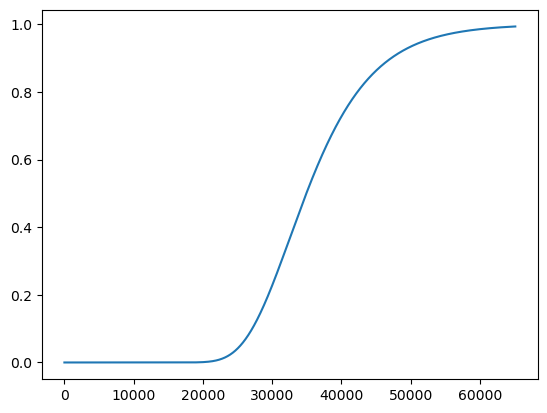

In [19]:
plot(growth_factor_list)
plt.show()

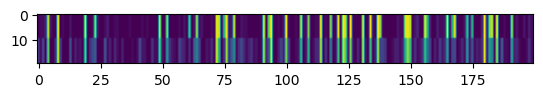

In [24]:

spike_monitor = Mv
off_time = 1

i = timepoint = 215

t_start_stimulus = time_points_dict["T"+ str(i)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(i)+"_e"]
t_start_recover = time_points_dict["T"+ str(i+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(i+off_time)+"_e"]
orig = spike_histogram(spike_monitor, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(spike_monitor, t_start=t_start_recover, t_stop=t_stop_recover).T[1]

imshow(np.row_stack((np.repeat(orig, 10).reshape(200, 10).T, np.repeat(recover, 10).reshape(200, 10).T)))

In [140]:
tst = Mv


TypeError: 'method' object is not subscriptable

In [143]:
def save_output(name = date_str):
    import pickle
    output = {"Mv": {"i":np.array(Mv.i), "t":np.array(Mv.t)}, 
              "Mh": {"i":np.array(Mh.i), "t":np.array(Mh.t)},
              "time_test_on":time_test_on,
              "time_test_off":time_test_off,
              "Ids":Ids,
              "timepoints":timepoints,
              "t_sim":t_sim,
              "time_points_dict":time_points_dict,
              "W":W,
              "b_v":b_v,
              "b_c":b_c,
              "b_h":b_h,
              "mB":mB,
              "Wvh":Wvh,
              "Wch":Wch,
              "mBv":mBv,
              "mBh":mBh,
              "sim_time":sim_time,
              "N_v":N_v,
              "N_c":N_c,
              "N_h":N_h,
              "beta_parameter":beta_parameter,
              "tau_rec":tau_rec,
              "dcmt":dcmt,
              "off_time":off_time}
    with open('output/output_'+date_str+'.pkl', 'wb') as handle: # Python 3:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [144]:
save_output()

In [145]:
def load_output(name = "output_"+date_str, path = "output/"):
    import pickle
    with open(path+name+".pkl", 'rb') as handle:
        output = pickle.load(handle)
    return output

In [146]:
output = load_output("output_2023-05-08")

In [147]:
output["Mv"]

In [34]:
# This calculates the hamming distances and percent match for all test patterns. 
# It uses the spike moitor ant the timepoints where the stimuli are presented

off_time = 1 # How many stimulus periods are used for recoverey period histogram

hamming_distances, percent_match, originals, recovered = hamming_distances_test(Mv, time_test_on, time_points_dict, off_time=off_time, 
                                                                                binarize = True, threshold = 100)

In [39]:
mean(percent_match[:5]) # allways 5 classes in one round

0.9410000000000001

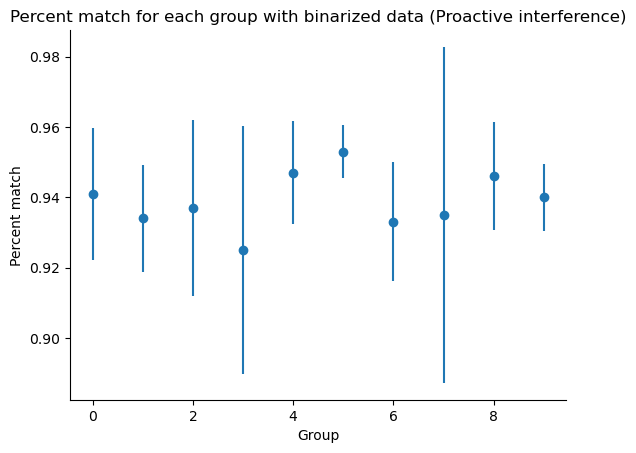

In [37]:
hd_table_between = np.array(hamming_distances[:50]).reshape(10, 5)
pm_table_between = np.array(percent_match[:50]).reshape(10, 5)
means_between = np.mean(pm_table_between, axis=1)
stds_between = np.std(pm_table_between, axis=1)

fig, ax = plt.subplots()
ax.errorbar(np.arange(10), means_between, stds_between, linestyle='None', marker='o')
ax.spines['top'].set_visible(False)
plt.xlabel("Group")
plt.ylabel("Percent match")
plt.title("Percent match for each group with binarized data (Proactive interference)")
ax.spines['right'].set_visible(False)
plt.show()



In [45]:
np.array(percent_match)[50:].reshape(10, 5) # each row is all test patterns for one group

array([[0.835, 0.815, 0.83 , 0.845, 0.885],
       [0.885, 0.815, 0.845, 0.9  , 0.915],
       [0.885, 0.915, 0.86 , 0.81 , 0.855],
       [0.84 , 0.89 , 0.87 , 0.86 , 0.82 ],
       [0.805, 0.885, 0.89 , 0.85 , 0.89 ],
       [0.87 , 0.89 , 0.81 , 0.865, 0.83 ],
       [0.835, 0.94 , 0.895, 0.87 , 0.915],
       [0.895, 0.845, 0.83 , 0.885, 0.89 ],
       [0.93 , 0.89 , 0.865, 0.87 , 0.925],
       [0.895, 0.91 , 0.83 , 0.83 , 0.9  ]])

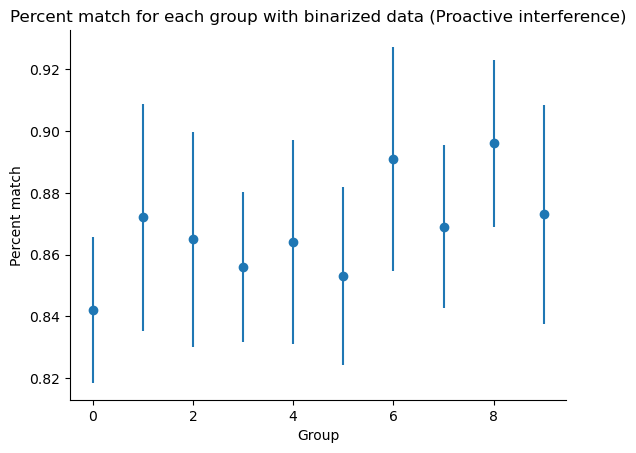

In [47]:
hd_table_within = np.array(hamming_distances[50:]).reshape(10, 5)
pm_table_within = np.array(percent_match[50:]).reshape(10, 5)
means_within = np.mean(pm_table_within, axis=1)
stds_within = np.std(pm_table_within, axis=1)

fig, ax = plt.subplots()
ax.errorbar(np.arange(10), means_within, stds_within, linestyle='None', marker='o')
ax.spines['top'].set_visible(False)
plt.xlabel("Group")
plt.ylabel("Percent match")
plt.title("Percent match for each group with binarized data (Retroactive interference)")
ax.spines['right'].set_visible(False)
plt.show()
